# Kaggle Healthcare Dataset — FAIR Reproducible Workflow

This notebook demonstrates a small, **reproducible** analysis using a healthcare CSV from Kaggle (uploader: *prasad22*).  
We load the data, do quick EDA, save outputs, and reflect on **FAIR** principles (Findable, Accessible, Interoperable, Reusable).

## 0) Setup & versions

In [34]:
import pathlib
import os
import textwrap
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,5)
DATA_DIR = pathlib.Path("../data") if pathlib.Path("../data").exists() else pathlib.Path("./dataset")
CSV_PATH = DATA_DIR / "healthcare.csv"

print({
    "csv_exists": CSV_PATH.exists(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__
})

{'csv_exists': True, 'pandas': '2.2.2', 'numpy': '2.2.6', 'matplotlib': '3.8.4'}


## 1) Load data and quick overview

In [35]:
df = pd.read_csv(CSV_PATH)
df.head()

display(df.shape)
display(df.dtypes)
df.sample(5)

(55500, 15)

Name                   object
Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Date of Admission      object
Doctor                 object
Hospital               object
Insurance Provider     object
Billing Amount        float64
Room Number             int64
Admission Type         object
Discharge Date         object
Medication             object
Test Results           object
dtype: object

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
39230,JosE JAcKSOn dVM,34,Male,O+,Diabetes,2022-06-25,Anthony Calderon,Lewis PLC,Aetna,29267.764182,219,Elective,2022-07-17,Lipitor,Abnormal
47633,joaNNe sALInAs,77,Female,AB-,Diabetes,2023-04-08,Brittany Brown,"and Wells, Acosta Moore",Medicare,11421.384438,143,Elective,2023-04-25,Lipitor,Inconclusive
41137,reBEccA MOORE,49,Female,O-,Obesity,2024-01-24,Derrick Mullins,Cruz-Hayes,Medicare,29175.831335,325,Urgent,2024-01-26,Aspirin,Inconclusive
28210,dErRiCk REED,59,Male,B-,Arthritis,2022-07-05,Robert Tucker,"and Case Osborn, Cook",Aetna,34190.281258,498,Urgent,2022-07-31,Ibuprofen,Abnormal
33936,ERin StANTon,59,Male,AB+,Arthritis,2019-06-01,Steven Lopez,"and Sloan Torres, Lucas",UnitedHealthcare,35602.157563,350,Urgent,2019-06-12,Lipitor,Abnormal


## 2) Light cleaning _ Clean data (dates, numeric conversion, missing values).

In [36]:
# Standardize name case
df["Name"] = df["Name"].str.title()

# Parse dates
for col in ["Date of Admission", "Discharge Date"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Basic sanity checks
# length of stay (days)
df["length_of_stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

# Clip/clean obvious numeric issues
df["Age"] = pd.to_numeric(df["Age"], errors="coerce").clip(lower=0, upper=120)
df["Billing Amount"] = pd.to_numeric(df["Billing Amount"], errors="coerce").clip(lower=0)

# Tidy categorical columns (strip spaces)
for c in ["Gender","Blood Type","Medical Condition","Doctor","Hospital",
          "Insurance Provider","Admission Type","Medication","Test Results"]:
    df[c] = df[c].astype(str).str.strip()

df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Name,55500,40235,Michael Williams,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,55500.0,NaN,NaN,NaN,51.539459,13.0,35.0,52.0,68.0,89.0,19.602454
Gender,55500,2,Male,27774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blood Type,55500,8,A-,6969,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medical Condition,55500,6,Arthritis,9308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date of Admission,55500,NaN,NaN,NaN,2021-11-01 01:02:22.443243008,2019-05-08 00:00:00,2020-07-28 00:00:00,2021-11-01 00:00:00,2023-02-03 00:00:00,2024-05-07 00:00:00,NaN
Doctor,55500,40341,Michael Smith,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hospital,55500,39876,LLC Smith,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Insurance Provider,55500,5,Cigna,11249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Billing Amount,55500.0,NaN,NaN,NaN,25540.28771,0.0,13241.224652,25538.069376,37820.508436,52764.276736,14209.67877


## 3) Exploratory Data Analysis (EDA)

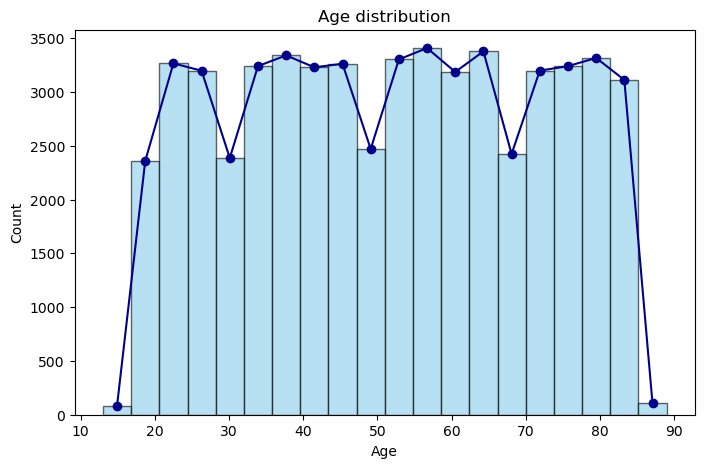

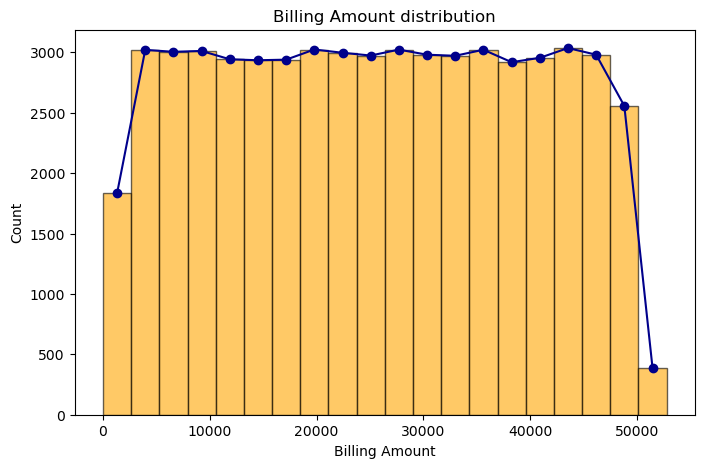

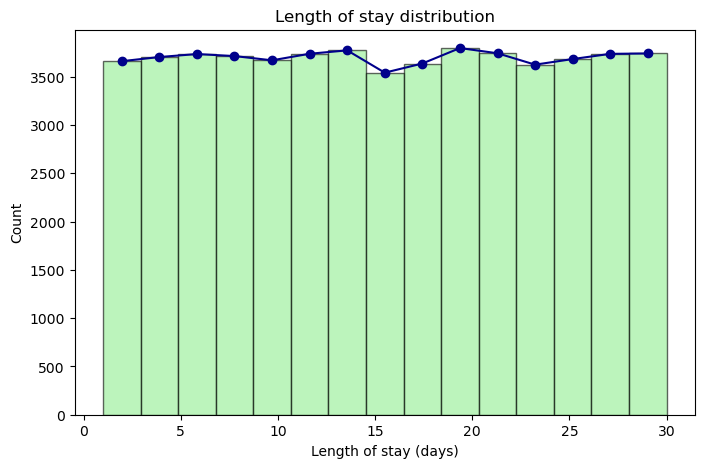

In [37]:
# Common plotting function: histogram + frequency polygon
def plot_hist_with_line(data, bins, color, xlabel, title):
    counts, bin_edges, _ = plt.hist(data.dropna(), bins=bins, alpha=0.6, 
                                    color=color, edgecolor="black")
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_centers, counts, "-o", color="darkblue")
    plt.xlabel(xlabel); plt.ylabel("Count"); plt.title(title)
    plt.show()

# Age distribution
plot_hist_with_line(df["Age"], bins=20, color="skyblue",
                    xlabel="Age", title="Age distribution")

# Billing Amount distribution
plot_hist_with_line(df["Billing Amount"], bins=20, color="orange",
                    xlabel="Billing Amount", title="Billing Amount distribution")

# Length of stay distribution
plot_hist_with_line(df["length_of_stay"], bins=15, color="lightgreen",
                    xlabel="Length of stay (days)", title="Length of stay distribution")

## 4) Feature engineering_ 	
Makes the raw dataset interoperable (FAIR).
	•	Derived features like length of stay are key predictors in healthcare.
	•	Binning ages helps model non-linear effects.

In [38]:
# Feature Engineering
df["length_of_stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
df["age_bin"] = pd.cut(df["Age"], bins=[0,18,35,50,65,120],
                       labels=["0-18","19-35","36-50","51-65","66+"])

df[["Age","age_bin","length_of_stay","Billing Amount"]].head()

,Age,age_bin,length_of_stay,Billing Amount
0,30,19-35,2,18856.281306
1,62,51-65,6,33643.327287
2,76,66+,15,27955.096079
3,28,19-35,30,37909.782410
4,43,36-50,20,14238.317814


## 5) Train/test split & Linear Regression
Modeling – Linear Regression - Predict Billing Amount using demographics & stay info.
Shows we can reproduce a predictive workflow.
	•	Metrics (R², MAE, RMSE) make performance transparent & comparable.
	•	Simple baseline model ensures reusability.


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Features and target
features = ["Age", "length_of_stay"]
X = df[features].fillna(0)
y = df["Billing Amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Train model
lin = LinearRegression()
lin.fit(X_train, y_train)

# Predictions
pred = lin.predict(X_test)

# Metrics
r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print({"R2": round(r2,4), "MAE": round(mae,2), "RMSE": round(rmse,2)})

{'R2': np.float64(-0.0007), 'MAE': np.float64(12207.73), 'RMSE': np.float64(14120.47)}


## 6) Predicted vs Actual Plot
	•	Makes results interpretable for humans.
	•	Helps check bias (under/overestimation).
	•	Improves accessibility of the workflow.

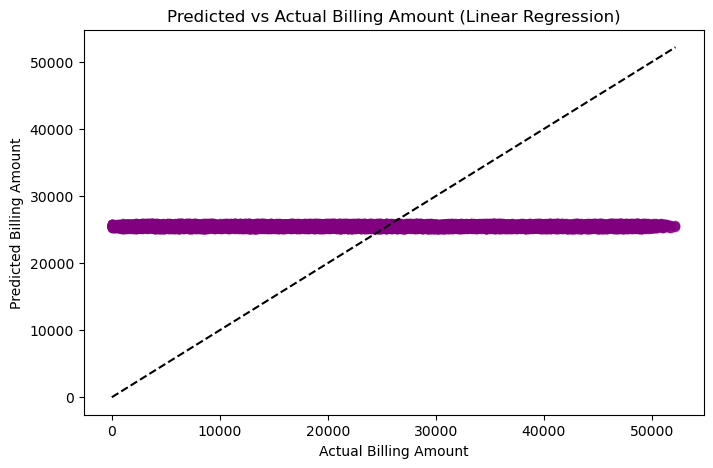

In [40]:
import matplotlib.pyplot as plt

plt.scatter(y_test, pred, alpha=0.6, color="purple")
plt.xlabel("Actual Billing Amount")
plt.ylabel("Predicted Billing Amount")
plt.title("Predicted vs Actual Billing Amount (Linear Regression)")
# reference line
mn, mx = float(min(y_test.min(), pred.min())), float(max(y_test.max(), pred.max()))
plt.plot([mn, mx], [mn, mx], color="black", linestyle="--")
plt.show()

## 7) Correlation Matrix
	•	Correlations highlight variable relationships.
	•	Adds scientific value and context.

                     Age  length_of_stay  Billing Amount
Age             1.000000        0.008220       -0.003824
length_of_stay  0.008220        1.000000       -0.005591
Billing Amount -0.003824       -0.005591        1.000000


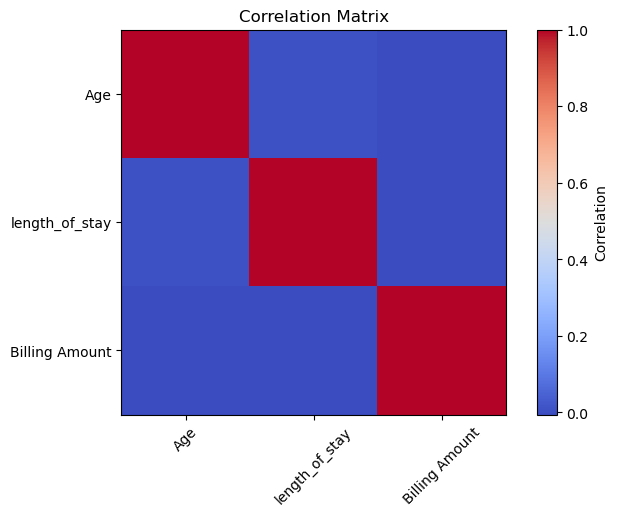

In [41]:
corr = df[["Age","length_of_stay","Billing Amount"]].corr()
print(corr)

plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()

In [42]:
import pathlib, json

OUT = pathlib.Path("../outputs")
OUT.mkdir(parents=True, exist_ok=True)

# Save predictions
out_df = X_test.copy()
out_df["actual"] = y_test
out_df["predicted"] = pred
out_df.to_csv(OUT/"predictions.csv", index=False)

# Save metrics
with open(OUT/"metrics.json", "w") as f:
    json.dump({"R2": float(r2), "MAE": float(mae), "RMSE": float(rmse)}, f, indent=2)

print("Saved outputs:", list(OUT.iterdir()))

Saved outputs: [PosixPath('../outputs/metrics.json'), PosixPath('../outputs/predictions.csv')]


## FAIR Mapping of This Healthcare Workflow

# Findable
	•	The dataset is clearly named (healthcare.csv) and stored in a dedicated dataset/ folder. 
The original dataset comes from Kaggle (uploader: *prasad22*). Kaggle datasets do **not** provide a DOI; to improve
findability and citability, this project can be archived on **Zenodo** (via a GitHub release), which will mint a DOI.
	•	Project is hosted on GitHub with a descriptive repository name and keywords in the README.
	•	Outputs (metrics, predictions) are saved in a structured outputs/ folder for easy discovery.

# Accessible
	•	All files are in open, widely supported formats (CSV, JSON, TXT).
	•	The full workflow can be rerun with one command using the environment.yml.
	•	Repository and outputs are openly available without proprietary software requirements.

# Interoperable
	•	Data and results are stored in standard formats (CSV/JSON) readable across tools.
	•	The environment uses standard Python libraries (pandas, scikit-learn, matplotlib).
	•	Code and outputs are organized so they can integrate into other workflows easily.

# Reusable
	•	The repository includes a clear license (MIT for code).
	•	Environment is pinned with specific versions, reducing reproducibility issues.
	•	Detailed README explains dataset source, workflow steps, and usage.
	•	Notebook is well-documented with markdown cells, making it easier for others to understand, adapt, and extend.

## Risk assessment

- **Upstream availability**: Kaggle datasets may be updated or removed.  
  *Mitigation*: include the CSV in the repo and optionally archive the repo to Zenodo for a DOI.
- **Package changes**: future updates (e.g., pandas 3.x) might change parsing defaults.  
  *Mitigation*: versions pinned in `environment.yml`.
- **Data quality**: missing or inconsistent values could bias results.  
  *Mitigation*: basic cleaning/validation, explicit dtype conversions, and clear reporting of missingness.